### Binary Intrusion Detection — Model Training & Comparison

This notebook performs binary classification (Attack vs Benign) on the engineered CIC-IIoT dataset `combined_engineered_features.csv`.
Primary objective: train K-Nearest Neighbors (KNN).  
Extended objective: train and compare multiple classifiers (KNN, Random Forest, SVM, Logistic Regression) with hyperparameter tuning, compute full set of metrics, plot ROC & confusion matrices, save best models and metric summary.

**Notes:**
- Input dataset path: `data/features/combined_engineered_features.csv`
- Output models saved to: `data/models/`
- Metric summary saved to: `data/models/metrics_summary.csv`

#### Imports & Config

In [11]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
import joblib
sns.set(style="whitegrid")
%matplotlib inline

# Paths
FEATURE_PATH = os.path.join("data", "features", "combined_engineered_features.csv")
MODELS_DIR = os.path.join("data", "models")
os.makedirs(MODELS_DIR, exist_ok=True)

#### Load & Prepare

In [12]:
# Cell: load data
df = pd.read_csv(FEATURE_PATH)
print("Loaded dataset:", df.shape)

# Ensure label1 exists
assert "label1" in df.columns, "label1 column not found in dataset!"

# Prepare features and binary target
X = df.drop(columns=["label1","label2","label3","label4","label_full"], errors='ignore')
y = df["label1"].apply(lambda x: 1 if str(x).lower() == "attack" else 0)

print("Feature matrix shape:", X.shape)
print("Class distribution:\n", y.value_counts().rename({0:"Benign",1:"Attack"}))


Loaded dataset: (685671, 45)
Feature matrix shape: (685671, 40)
Class distribution:
 label1
Benign    400672
Attack    284999
Name: count, dtype: int64


#### Train/Test Split

In [13]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (548536, 40) Test shape: (137135, 40)


#### Evaluate model (metrics + plots)

In [14]:
# Cell: helper functions
def compute_metrics(y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)  # sensitivity
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    roc_auc = roc_auc_score(y_true, y_prob) if (y_prob is not None) else np.nan
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "specificity": spec,
        "f1": f1,
        "roc_auc": roc_auc,
        "confusion_matrix": cm
    }

def plot_confusion(cm, labels=["Benign","Attack"], title="Confusion Matrix"):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def plot_roc(y_true, y_prob, label):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")
    return auc


#### Define Models + Parameter Grids

In [15]:
model_defs = {}

# --- KNN ---
model_defs["knn"] = {
    "estimator": KNeighborsClassifier(),
    "param_grid": {
        "n_neighbors": [3, 5, 7, 9, 11],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan", "minkowski"]
    }
}

# --- Naive Bayes ---
model_defs["nb"] = {
    "estimator": GaussianNB(),
    "param_grid": {
        "var_smoothing": np.logspace(-10, -6, 5)
    }
}

# --- Decision Tree ---
model_defs["dt"] = {
    "estimator": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "param_grid": {
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": [10, 20, 30, 40, 50, None],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 2, 4, 6, 8],
        "max_features": [None, "sqrt", "log2"],
        "class_weight": [None, "balanced"]
    }
}

MODELS_TO_RUN = ["knn", "nb", "dt"]

print(f"Models to run: {MODELS_TO_RUN}")


Models to run: ['knn', 'nb', 'dt']


In [16]:
def train_and_evaluate_model(model_key, model_def, X_train, X_test, y_train, y_test, base_dir, cv_folds=3, n_iter=5):
    """Train, evaluate and save results for a single model."""
    spec = model_def
    estimator = spec["estimator"]
    param_grid = spec["param_grid"]

    MODEL_DIR = os.path.join(base_dir, model_key)
    os.makedirs(MODEL_DIR, exist_ok=True)

    print(f"\n=== Training {model_key.upper()} ===")

    # --- Randomized SearchCV ---
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    search = RandomizedSearchCV(
        estimator,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring="f1",
        cv=cv,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )
    search.fit(X_train, y_train)
    best = search.best_estimator_

    # --- Evaluate ---
    y_pred = best.predict(X_test)
    y_prob = best.predict_proba(X_test)[:, 1] if hasattr(best, "predict_proba") else best.decision_function(X_test)
    metrics = compute_metrics(y_test, y_pred, y_prob)

    # --- Save model ---
    model_path = os.path.join(MODEL_DIR, f"{model_key}_best_model.pkl")
    joblib.dump(best, model_path)

    # --- Save confusion matrix ---
    cm = metrics["confusion_matrix"]
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
                xticklabels=["Benign","Attack"], yticklabels=["Benign","Attack"])
    plt.title(f"{model_key.upper()} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    cm_path = os.path.join(MODEL_DIR, f"{model_key}_confusion_matrix.png")
    plt.tight_layout(); plt.savefig(cm_path, dpi=300); plt.close()

    # --- Save ROC curve ---
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC={roc_auc:.3f}")
    plt.plot([0,1],[0,1],"k--", lw=1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC - {model_key.upper()}"); plt.legend(loc="lower right")
    roc_path = os.path.join(MODEL_DIR, f"{model_key}_roc_curve.png")
    plt.tight_layout(); plt.savefig(roc_path, dpi=300); plt.close()

    print(f"Saved model, confusion matrix, and ROC for {model_key}")

    # --- Return summary row ---
    return {
        "model": model_key,
        "best_params": search.best_params_,
        "cv_f1": search.best_score_,
        "test_accuracy": metrics["accuracy"],
        "test_precision": metrics["precision"],
        "test_recall": metrics["recall"],
        "test_specificity": metrics["specificity"],
        "test_f1": metrics["f1"],
        "test_roc_auc": metrics["roc_auc"]
    }

In [17]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_DIR = os.path.join("results", f"model_results_{timestamp}")
os.makedirs(RUN_DIR, exist_ok=True)
print(f"Results will be saved under: {RUN_DIR}")

results = []

for key in MODELS_TO_RUN:
    result_row = train_and_evaluate_model(
        model_key=key,
        model_def=model_defs[key],
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
        base_dir=RUN_DIR,
        cv_folds=2,
        n_iter=2
    )
    results.append(result_row)

metrics_df = pd.DataFrame(results)
metrics_csv = os.path.join(RUN_DIR, "metrics_summary_all_models.csv")
metrics_df.to_csv(metrics_csv, index=False)
print(f"\nMetrics summary saved: {metrics_csv}")
display(metrics_df)

Results will be saved under: results\model_results_20251025_125628

=== Training KNN ===
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Saved model, confusion matrix, and ROC for knn

=== Training NB ===
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Saved model, confusion matrix, and ROC for nb

=== Training DT ===
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Saved model, confusion matrix, and ROC for dt

Metrics summary saved: results\model_results_20251025_125628\metrics_summary_all_models.csv


,model,best_params,cv_f1,test_accuracy,test_precision,test_recall,test_specificity,test_f1,test_roc_auc
0,knn,"{'weights': 'distance', 'n_neighbors': 7, 'met...",0.946871,0.964159,0.992176,0.921035,0.994834,0.955283,0.983582
1,nb,{'var_smoothing': 1e-06},0.860736,0.895833,0.976485,0.767877,0.986847,0.859708,0.908703
2,dt,"{'min_samples_split': 2, 'min_samples_leaf': 1...",0.955548,0.966887,0.992490,0.927351,0.995008,0.958815,0.982929


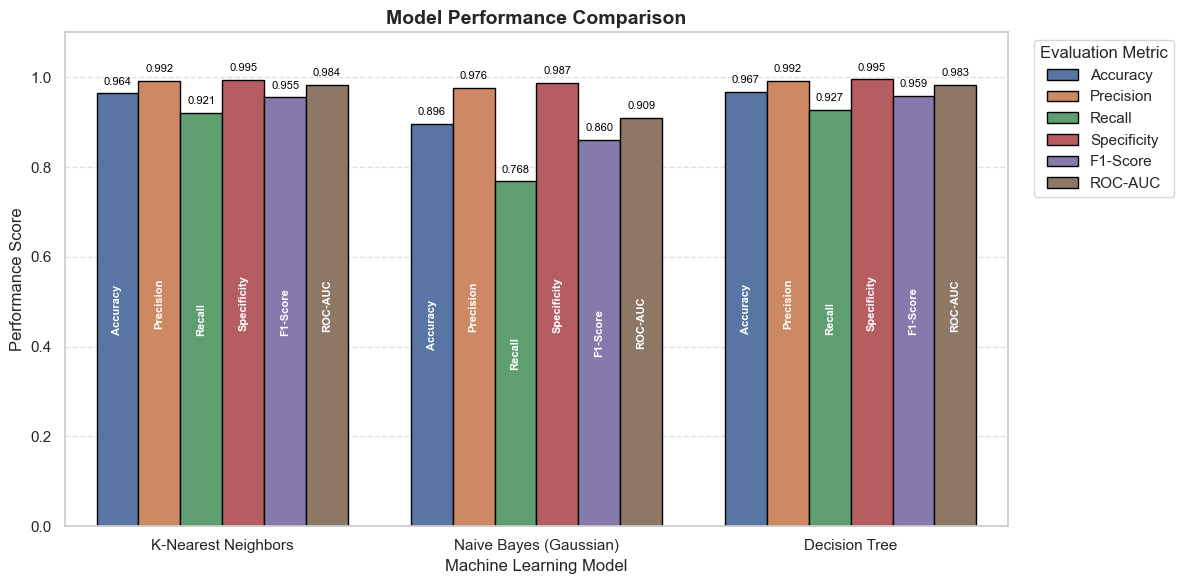

 Saved labeled grouped comparison plot: results\model_results_20251025_125628\model_grouped_comparison_with_internal_labels.png


In [18]:
model_name_map = {
    "knn": "K-Nearest Neighbors",
    "nb": "Naive Bayes (Gaussian)",
    "dt": "Decision Tree",
}
metric_name_map = {
    "test_accuracy": "Accuracy",
    "test_precision": "Precision",
    "test_recall": "Recall",
    "test_specificity": "Specificity",
    "test_f1": "F1-Score",
    "test_roc_auc": "ROC-AUC",
}

metrics_to_plot = list(metric_name_map.keys())


plot_df = metrics_df.melt(
    id_vars=["model"],
    value_vars=metrics_to_plot,
    var_name="Metric",
    value_name="Score",
).copy()

plot_df["Model"] = plot_df["model"].map(model_name_map).fillna(plot_df["model"])
plot_df["Metric"] = plot_df["Metric"].map(metric_name_map).fillna(plot_df["Metric"])


hue_order = [metric_name_map[m] for m in metrics_to_plot]
x_order = plot_df["Model"].drop_duplicates().tolist()

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(
    data=plot_df,
    x="Model",
    y="Score",
    hue="Metric",
    hue_order=hue_order,
    order=x_order,
    edgecolor="black",
)

legend = ax.get_legend()
legend_labels = [t.get_text() for t in legend.get_texts()] if legend else hue_order


for i, container in enumerate(ax.containers):
    metric_label = legend_labels[i] if i < len(legend_labels) else hue_order[i]
    for bar in container:
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2.0


        text_color = "white" if height >= 0.25 else "black"
        ax.text(
            x,
            height * 0.5,             
            metric_label,
            ha="center",
            va="center",
            rotation=90,           
            fontsize=8,
            color=text_color,
            weight="bold",
            clip_on=True,
        )

        ax.text(
            x,
            height + 0.015,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=8,
            color="black",
        )

ax.set_title("Model Performance Comparison", fontsize=14, weight="bold")
ax.set_xlabel("Machine Learning Model", fontsize=12)
ax.set_ylabel("Performance Score", fontsize=12)
ax.set_ylim(0, 1.10)
ax.grid(axis="y", linestyle="--", alpha=0.6)

ax.legend(title="Evaluation Metric", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

out_path = os.path.join(RUN_DIR, "model_grouped_comparison_with_internal_labels.png")
plt.savefig(out_path, dpi=300)
plt.show()
print(f" Saved labeled grouped comparison plot: {out_path}")